In [1]:
import os
import warnings
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import colorcet as cc
import healpy as hp
from astropy.time import Time

from rubin_scheduler.site_models import Almanac
from rubin_scheduler.utils import Site
from rubin_scheduler.data import get_data_dir

#from rubin_scheduler.scheduler.model_observatory import ModelObservatory, KinemModel
#from rubin_scheduler.site_models import ConstantSeeingData, ConstantWindData
#from rubin_scheduler.scheduler.model_observatory import tma_movement, rotator_movement
from rubin_scheduler.scheduler.example import get_model_observatory, update_model_observatory_sunset
from rubin_scheduler.scheduler.example import get_basis_functions_field_survey, get_field_survey
from rubin_scheduler.scheduler.example import get_sv_fields, prioritize_fields, get_comcam_sv_schedulers

from rubin_scheduler.scheduler import basis_functions
from rubin_scheduler.scheduler import features
from rubin_scheduler.scheduler.detailers import CameraSmallRotPerObservationListDetailer
from rubin_scheduler.scheduler.surveys import FieldSurvey
from rubin_scheduler.scheduler.schedulers import CoreScheduler, ComCamFilterSched

from rubin_scheduler.scheduler import sim_runner
from rubin_scheduler.scheduler.utils import SchemaConverter

In [2]:
at_usdf = False
if at_usdf:
    os.environ["RUBIN_SIM_DATA_DIR"] = "/sdf/group/rubin/shared/rubin_sim_data"
print("Using rubin_sim_data from ", get_data_dir())

Using rubin_sim_data from  /Users/lynnej/rubin_sim_data


In [3]:
# Setting the start of the *survey* (and keeping this the same) is important for the Model Observatory and Scheduler,
# because this sets an overall dither pattern per night, but also helps track things that may 
# otherwise change per night ... for SV surveys, might not be totally necessary, but is good practice
# (you can change the *day* / mjd that you are simulating, of course, but mjd_start should remain the same)

dayobs = '2024-09-09'
survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')
survey_start.mjd

60562.5

In [4]:
# Don't have to do this, but can grab almanac information

almanac = Almanac(mjd_start = survey_start.mjd)

def show_almanac_info(dayobs):
    night_info = almanac.get_sunset_info(evening_date=dayobs, longitude=Site('LSST').longitude_rad)
    
    dd = []
    for val, col in zip(night_info, night_info.dtype.names):
        if col == 'night':
            continue
        else:
            print(col, val, Time(val, format='mjd', scale='utc').iso)
    
    # And can check on the lunar phase -- this goes from 0 (new) to 100 (full)
    moon_phase = almanac.get_sun_moon_positions(night_info['moonrise'])['moon_phase']
    print(f'moonphase(%) {moon_phase.round(2)}')

show_almanac_info(dayobs)

sunset 60562.936555093154 2024-09-09 22:28:38.360
sun_n12_setting 60562.975207073614 2024-09-09 23:24:17.891
sun_n18_setting 60562.99454106344 2024-09-09 23:52:08.348
sun_n18_rising 60563.39397472935 2024-09-10 09:27:19.417
sun_n12_rising 60563.4132887749 2024-09-10 09:55:08.150
sunrise 60563.45188789442 2024-09-10 10:50:43.114
moonrise 60563.62073250674 2024-09-10 14:53:51.289
moonset 60563.19181374041 2024-09-10 04:36:12.707
moonphase(%) 46.25


In [5]:
## field survey to be tested .. this should make it unnecessary to specify particular notes in features for basis functions.
# See examples of key basis functions .. you can call basis_function.__calc_rewards(conditions) to see what the basis function values look like.sv

In [6]:
# These can be imported from rubin_scheduler, but leave here too for customization

def get_basis_functions_field_survey_custom(
    nside: int = 32,
    wind_speed_maximum: float = 10,
) -> list[basis_functions.BaseBasisFunction]:
    """Get the basis functions for a field survey.

    Parameters
    ----------
    nside : `int`
        The nside value for the healpix grid.
    wind_speed_maximum : `float`
        Maximum wind speed tolerated for the observations of the survey,
        in m/s.

    Returns
    -------
    `list` of `basis_functions.BaseBasisFunction`
    """
    sun_alt_limit = -12.0
    moon_distance = 30

    bfs = [
        basis_functions.NotTwilightBasisFunction(sun_alt_limit=sun_alt_limit),
        basis_functions.MoonAvoidanceBasisFunction(nside=nside, moon_distance=moon_distance),
        basis_functions.AvoidDirectWind(
            wind_speed_maximum=wind_speed_maximum, nside=nside
        ),
        # Mask parts of the sky in alt/az, including parts of the sky that will move into this area
        # (replaces azimuth mask and zenith shadow mask, should also be able to replace airmass basis function)
        basis_functions.AltAzShadowMaskBasisFunction(
            nside=nside, min_alt=22, max_alt=83, min_az=0.0, max_az=360.0, shadow_minutes=30
        ),
        # Avoid revisits within 30 minutes -- sequence is about 60 minutes long, don't repeat immediately
        basis_functions.AvoidFastRevisitsBasisFunction(nside=nside, filtername=None, gap_min=30.0),
        # reward fields which are rising, but don't mask out after zenith
        basis_functions.RewardRisingBasisFunction(nside=nside, slope=0.1, penalty_val=0),
        # Reward parts of the sky which are darker -- note that this is only for r band, so relying on
        # skymap in r band .. if there isn't a strong reason to go with the darkest pointing,
        # it might be reasonable to just drop this basis function
        basis_functions.M5DiffBasisFunction(filtername='r', nside=nside),
    ]
    return bfs

def get_field_survey_custom(field_ra_deg, field_dec_deg, field_name, basis_functions, detailers, nside=32):
    
    field_survey = FieldSurvey(basis_functions, 
                                   field_ra_deg,
                                    field_dec_deg,
                                    sequence='ugrizy',
                                    nvisits={'u': 20, 'g': 20, 'r': 20, 'i': 20, 'z': 20, 'y': 20},
                                    exptimes={'u': 38, 'g': 30, 'r': 30, 'i': 30, 'z': 30, 'y': 30},
                                    nexps={'u': 1, 'g': 2, 'r': 2, 'i': 2, 'z': 2, 'y': 2},
                                    ignore_obs=None,
                                    accept_obs=[field_name],
                                    survey_name=field_name,
                                    scheduler_note=None,
                                    readtime=2.4,
                                    filter_change_time=120.0,
                                    nside=nside,
                                    flush_pad=30.0,
                                    detailers=detailers)
    return field_survey

In [7]:
## Set up the default scheduler, just prioritizing different fields.

field_dict = get_sv_fields()
tiers = prioritize_fields(priority_fields=[['EDFS_A', 'EDFS_B'], ['DEEP_B0']], field_dict=field_dict)
scheduler, filter_scheduler = get_comcam_sv_schedulers(starting_tier=0, tiers=tiers, field_dict=field_dict)

scheduler.survey_lists

[[<FieldSurvey survey_name='EDFS_A', RA=1.02799892942466, dec=-0.8607091206210036 at 0x1a10cd5d0>,
  <FieldSurvey survey_name='EDFS_B', RA=1.1100294042683936, dec=-0.8307767239493009 at 0x1a1bd26d0>],
 [<FieldSurvey survey_name='DEEP_B0', RA=5.410520681182422, dec=-0.33161255787892263 at 0x1a1b93110>],
 [<FieldSurvey survey_name='Rubin_SV_095_-25', RA=1.6580627893946132, dec=-0.4363323129985824 at 0x1a1b811d0>,
  <FieldSurvey survey_name='Rubin_SV_125_-15', RA=2.181661564992912, dec=-0.2617993877991494 at 0x1a1b7af50>,
  <FieldSurvey survey_name='DESI_SV3_R1', RA=3.134611336581816, dec=0.0 at 0x1a1b918d0>,
  <FieldSurvey survey_name='Rubin_SV_225_-40', RA=3.9269908169872414, dec=-0.6981317007977318 at 0x1a1bd9a10>,
  <FieldSurvey survey_name='DEEP_A0', RA=3.7699111843077517, dec=-0.2181661564992912 at 0x1a1b08850>,
  <FieldSurvey survey_name='Rubin_SV_250_2', RA=4.363323129985824, dec=0.03490658503988659 at 0x1a1b368d0>,
  <FieldSurvey survey_name='Rubin_SV_300_-41', RA=5.2359877559829

In [8]:
verbose = False

dayobs = '2024-09-09'
survey_start = Time(f'{dayobs}T12:00:00', format='isot', scale='utc')
mjd_now = survey_start.mjd

# Set up again to be sure all is 'clean'
field_dict = get_sv_fields()
tiers = prioritize_fields(priority_fields=[['EDFS_A', 'EDFS_B'], ['DEEP_B0']], field_dict=field_dict)
scheduler, filter_scheduler = get_comcam_sv_schedulers(starting_tier=0, tiers=tiers, field_dict=field_dict)

observatory = get_model_observatory(dayobs)
observatory = update_model_observatory_sunset(observatory, filter_scheduler)
conditions = observatory.return_conditions()

mjd = observatory.mjd
mjd_end = conditions.sun_n12_rising
survey_length = 30 #mjd_end - mjd

observatory, scheduler, observations = sim_runner(observatory,
                                                scheduler,
                                                filter_scheduler=filter_scheduler,
                                                mjd_start=mjd,
                                                survey_length=survey_length,
                                                n_visit_limit=None,
                                                step_none=10.0,
                                                verbose=True,
                                                record_rewards=False,
                                                start_result_size=int(2e4),
                                                append_result_size=int(2.5e4),
                                            )

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/skybrightness_pre/sky_model_pre.py:352: UserWarning: Requested MJD between sunrise and sunset, returning closest maps
  warnings.warn("Requested MJD between sunrise and sunset, returning closest maps")
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:289: RuntimeWarning: All-NaN axis encountered
  rewards[i] = np.nanmax(survey.calc_reward_function(self.conditions))
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:291: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(rewards) > -np.inf:


progress = 10.42%

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:294: RuntimeWarning: All-NaN slice encountered
  if (np.nanmax(rewards) == -np.inf) | (np.isnan(np.nanmax(rewards))):
Failed to fill queue at time [60566.12452833]
/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/sim_runner.py:115: UserWarning: No observation. Step into the future and trying again.
  warnings.warn("No observation. Step into the future and trying again.")
Failed to fill queue at time [60566.13147277]
Failed to fill queue at time [60566.13841722]


progress = 13.62%

Failed to fill queue at time [60567.06578078]
Failed to fill queue at time [60567.07272522]
Failed to fill queue at time [60567.07966967]


progress = 13.76%

Failed to fill queue at time [60567.11719434]
Failed to fill queue at time [60567.12413878]
Failed to fill queue at time [60567.13108323]


progress = 100.04%Skipped 9 observations
Flushed 0 observations from queue for being stale
Completed 25203 observations
ran in 1 min = 0.0 hours


In [9]:
sc = SchemaConverter()
visits = sc.obs2opsim(observations)

In [10]:
# Let's check in on sequences, because there are some issues
visits.groupby('target')['observationStartMJD'].count()

target
DEEP_B0             3900
EDFS_A              9030
EDFS_B              7960
ELAIS_S1            3240
Rubin_SV_225_-40     120
Rubin_SV_250_2       473
Rubin_SV_280_-48     180
Rubin_SV_300_-41     240
XMM_LSS               60
Name: observationStartMJD, dtype: int64

In [11]:
# How many observations per target, and are sequences completing? 
targets = visits.target.values
prev_target = np.concatenate([np.array([targets[0]], dtype=object), targets[0:-1]])
visits['prev_target'] = prev_target

change_sequences = np.where(visits.prev_target != visits.target)[0]
seq = pd.DataFrame(list(zip(change_sequences, np.diff(change_sequences))), columns=['ObservationID', 'seq_length'])
seq.query('seq_length != 60')

,ObservationID,seq_length
13,840,52
28,1732,45
43,2617,40
47,2837,53
58,3490,7
61,3617,120
71,4277,20
86,5137,40
101,6017,30
116,6887,31


In [51]:
# the time from the start of one exposure to the start of the next exposure:
slew_to_next_visit = visits['slewTime'][1:]
expected_overheads = visits['visitTime'][:-1].values + slew_to_next_visit.values
# Compare to the actual time between visits
actual_overheads = np.diff(visits['observationStartMJD'])*24*60*60 
# We can look at the difference to identify gaps in visits (seconds)
diff = np.abs(expected_overheads - actual_overheads)
indx = np.where((diff > 1) & (diff < 6*60*60))[0]
breaks = []
for i in indx:
    b1 = visits.iloc[i]['observationStartMJD']
    b2 = visits.iloc[i+1]['observationStartMJD']
    breaks.append([b1, b2])
print(indx)
print(visits['night'][indx])
print(breaks)

[2949 3676 3736]
2949    4
3676    5
3736    5
Name: night, dtype: int64
[[60566.124130181226, 60566.14737733611], [60567.06538263201, 60567.08851129665], [60567.116796191105, 60567.14004759276]]


/var/folders/tr/bjzqy0h17kx31fhndw6050d80000gn/T/ipykernel_93506/536139739.py:15: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  print(visits['night'][indx])


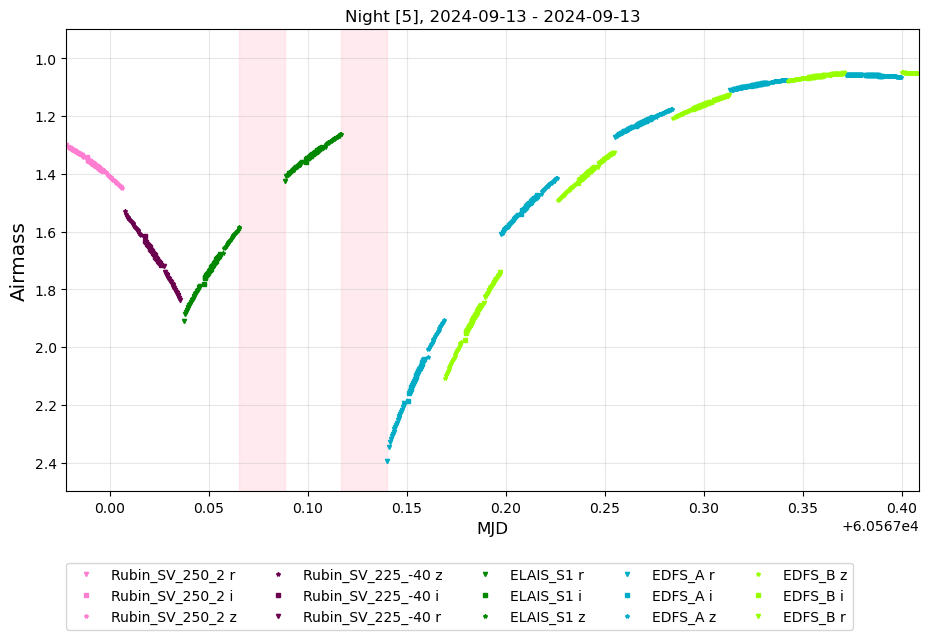

In [64]:
def plot_airmass(visits, nights):
    slew_to_next_visit = visits['slewTime'][1:]
    expected_overheads = visits['visitTime'][:-1].values + slew_to_next_visit.values
    # Compare to the actual time between visits
    actual_overheads = np.diff(visits['observationStartMJD'])*24*60*60 
    # We can look at the difference to identify gaps in visits (seconds)
    diff = np.abs(expected_overheads - actual_overheads)
    indx = np.where((diff > 1) & (diff < 6*60*60))[0]
    breaks = []
    for i in indx:
        b1 = visits.iloc[i]['observationStartMJD']
        b2 = visits.iloc[i+1]['observationStartMJD']
        breaks.append([b1, b2])
        
    filtershapes = {'u': 'o', 'g': '^', 'r': 'v', 'i': 's', 'z': '*', 'y': 'p'}
    filtercolors = {'u': '#005BDB',
                    'g': '#3DA952',
                    'r': '#c61c00',
                    'i': '#997500',
                    'z': '#CE0D77',
                    'y': '#5d0000'}
    fieldcolors = {}
    for i, t in enumerate(visits.target.unique()):
        fieldcolors[t] = cc.glasbey[i]
    
    
    plt.figure(figsize=(11, 6))
    if len(breaks) > 0:
        for b in breaks:
            plt.fill_between(b, 2.5, 0.0, color='pink', alpha=0.3)

    for night in nights:
        nvisits = visits.query('night == @night')
        for t in nvisits.target.unique():
            vv = nvisits.query('target == @t')
            for f in vv['filter'].unique():
                vvf = vv.query('filter == @f')
                label = f'{t} {f}'
                plt.plot(vvf.observationStartMJD, vvf.airmass, linestyle='', 
                         marker=filtershapes[f], markersize=3, color=fieldcolors[t], label=label)
    plt.legend(loc=(0.00 , -0.3), ncols=len(nvisits.target.unique()))
    plt.ylim(2.5, 0.9)
    n = nights[0]
    tmin = visits.query('night == @n').observationStartMJD.min()
    n = nights[-1]
    tmax = visits.query('night == @n').observationStartMJD.max()
    plt.xlim(tmin, tmax)
    plt.grid(alpha=0.3)
    plt.xlabel("MJD", fontsize='large')
    plt.ylabel("Airmass", fontsize='x-large')
    plt.title(f"Night {nights}, {Time(tmin, format='mjd', scale='utc').isot.split('T')[0]} - {Time(tmax-1, format='mjd', scale='utc').isot.split('T')[0]}")


plot_airmass(visits, nights=[5])

# still some more debugging of survey setup required 

In [65]:
# For more debugging: 
# Find visit number, return observatory and scheduler to that state, and see. 

# To see what happens if we vary the scheduler setup, run the survey forward to a given night, then change the setup and resume running.

# If adding observations from previous nights, it's safe to use scheduler.add_observation(obs) in a loop over those observations
# But for observations within the current night, the model observatory usually needs us to run forward in time to ensure it's in the same state.

In [25]:
reload_observations = observations[np.where(observations['night'] < 10)]
print(len(observations), len(reload_observations), reload_observations['night'].max())

25203 7786 9


In [26]:
# What happened in the first nine nights? Let's pick new priority fields
pd.DataFrame(reload_observations).groupby('target')['target'].count()

target
DEEP_B0              900
EDFS_A              2578
EDFS_B              2215
ELAIS_S1            1020
Rubin_SV_225_-40     120
Rubin_SV_250_2       473
Rubin_SV_280_-48     180
Rubin_SV_300_-41     240
XMM_LSS               60
Name: target, dtype: int64

In [33]:
# Set up again to be sure all is 'clean' -- can do this if we want to stop at a particular nvisit during the night.

# Set up again to be sure all is 'clean'
field_dict = get_sv_fields()
# changing the priority fields 
tiers = prioritize_fields(priority_fields=[['DEEP_B0', 'Rubin_SV_300_-41', 'ELAIS_S1']], field_dict=field_dict)
scheduler, filter_scheduler = get_comcam_sv_schedulers(starting_tier=0, tiers=tiers, field_dict=field_dict)

observatory = get_model_observatory(dayobs)

# If we want to add previous night's observations, this is safe
# (define reload_observations as the observations prior to night X)

for obs in reload_observations:
    scheduler.add_observation(obs)
observatory.mjd = obs['mjd'] + 3/24.0
print("last observation from reload:", obs['mjd'])
observatory = update_model_observatory_sunset(observatory, filter_scheduler)
conditions = observatory.return_conditions()
print("updated observatory time", conditions.mjd)

mjd = observatory.mjd
mjd_end = conditions.sun_n12_rising
survey_length = 20 # mjd_end - mjd

# But for observations within this night - run up to the time in question like this: 
#nvisits = 121
nvisits = None

observatory, scheduler, newobservations = sim_runner(observatory,
                                                scheduler,
                                                filter_scheduler=filter_scheduler,
                                                mjd_start=mjd,
                                                survey_length=survey_length,
                                                n_visit_limit=nvisits,
                                                step_none=10.0,
                                                verbose=True,
                                                record_rewards=False,
                                                start_result_size=int(2e4),
                                                append_result_size=int(2.5e4),
                                            )

observations2 = np.concatenate([reload_observations, newobservations])

last observation from reload: 60571.40555476309
updated observatory time 60571.97859491361


/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:289: RuntimeWarning: All-NaN axis encountered
  rewards[i] = np.nanmax(survey.calc_reward_function(self.conditions))


progress = 1.47%

/Users/lynnej/lsst_repos/rubin_scheduler/rubin_scheduler/scheduler/schedulers/core_scheduler.py:291: RuntimeWarning: All-NaN slice encountered
  if np.nanmax(rewards) > -np.inf:


progress = 100.04%Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 16131 observations
ran in 0 min = 0.0 hours


In [34]:
sc = SchemaConverter()
visits2 = sc.obs2opsim(observations2)
visits2.groupby('target')['observationStartMJD'].count()

target
DEEP_B0             4903
ECDFS                  2
EDFS_A              2578
EDFS_B              3895
ELAIS_S1            9380
Rubin_SV_225_-40     120
Rubin_SV_250_2       473
Rubin_SV_280_-48     180
Rubin_SV_300_-41    1260
XMM_LSS             1126
Name: observationStartMJD, dtype: int64

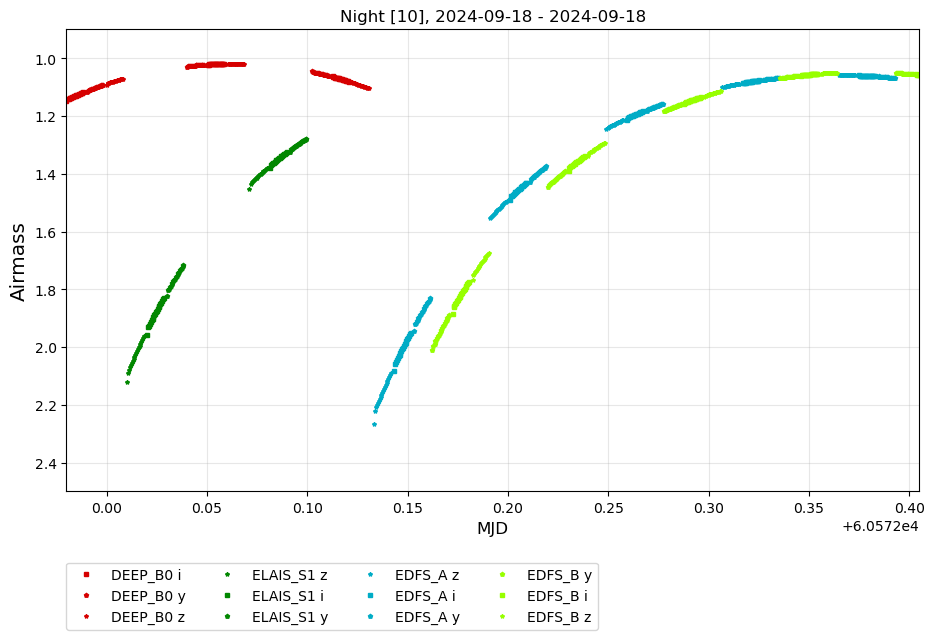

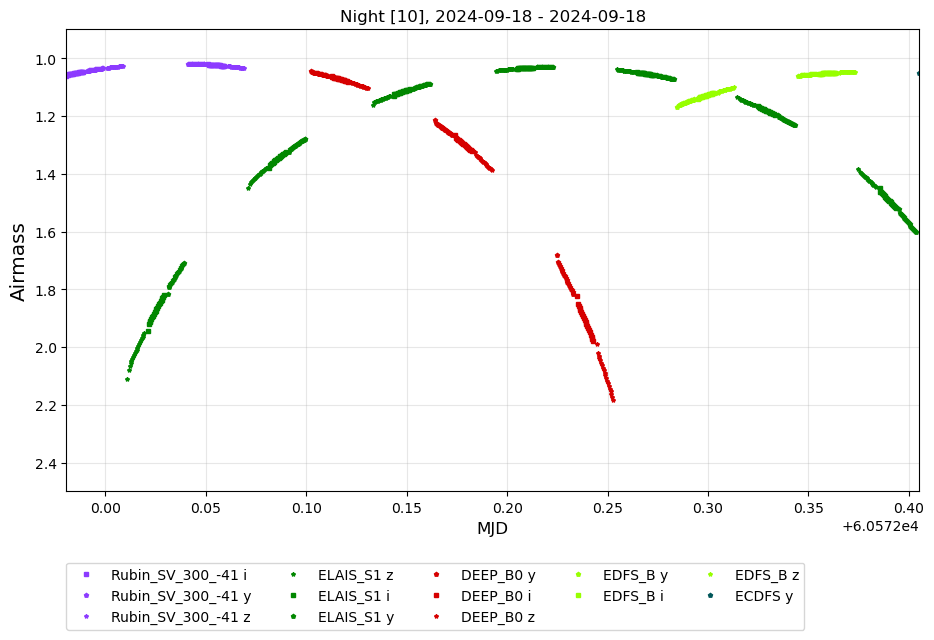

In [66]:
plot_airmass(visits, nights=[10])
plot_airmass(visits2, nights=[10])

In [37]:
# OR .. if we were debugging and want to look at state of the scheduler, surveys, or basis functions ..
print("Check each of these field surveys at the time of conditions")
print("Time", observatory.mjd, "previous queue fill", conditions.mjd)

newconditions = observatory.return_conditions()
print(f"Checking conditions at {newconditions.mjd}")
df = []
for s in scheduler.survey_lists[0]:
    reward = s.calc_reward_function(newconditions)
    field_alt = newconditions.alt[s.indx]
    df.append([s.survey_name, s.extra_features['ObsRecord'](), reward, np.degrees(field_alt)])
pd.DataFrame(df, columns=['target', 'nobs recorded', 'current reward', 'field alt'])

Check each of these field surveys at the time of conditions
Time [60591.98736908] previous queue fill 60571.97859491361
Checking conditions at [60591.98736908]


,target,nobs recorded,current reward,field alt
0,DEEP_B0,4903,-3.406115,77.027501
1,Rubin_SV_300_-41,1260,-2.706224,78.139122
2,ELAIS_S1,9380,-0.014381,35.991225


In [42]:
# winning survey at the time the queue was filled is:
print('winner at (potentially previous) queue fill', scheduler.survey_index)
sidx = [0, 2] #scheduler.survey_index
s = scheduler.survey_lists[sidx[0]][sidx[1]]
print(f"Rewards for {s.survey_name} at {observatory.mjd}")
for bf in s.basis_functions:
    val = bf(newconditions)
    if not np.isscalar(val):
        val = np.sum(val[s.indx])
    print(bf.label(), bf.check_feasibility(newconditions), val)

winner at (potentially previous) queue fill [None, None]
Rewards for ELAIS_S1 at [60591.98736908]
NotTwilight @7041160528 True 0
MoonAvoidance @7036609040 True 1.0
AvoidDirectWind @7036608080 True -0.3237217607450824
AltAzShadowMask @7037816720 True 0.0
AvoidFastRevisits @7037818704 True 1.0
RewardRising @7037821648 True 0.5107442372219397
M5Diff r @7037821264 True -2.2876904138951737


In [21]:
# Can also run one visit at a time 
observatory, scheduler, newobservations = sim_runner(observatory,
                                                scheduler,
                                                filter_scheduler=filter_scheduler,
                                                mjd_start=mjd,
                                                survey_length=survey_length,
                                                n_visit_limit=1,
                                                step_none=10.0,
                                                verbose=True,
                                                record_rewards=False,
                                                start_result_size=int(2e4),
                                                append_result_size=int(2.5e4),
                                            )

print(newobservations['note'], newobservations['ID'],  observatory.mjd, len(scheduler.queue), 
      np.degrees(newobservations['alt']), np.degrees(newobservations['az']), np.degrees(newobservations['rotTelPos']), newobservations['airmass'])

Skipped 0 observations
Flushed 0 observations from queue for being stale
Completed 1 observations
ran in 0 min = 0.0 hours
['Rubin_SV_300_-41'] [121] [60562.99534514] 58 [68.11709694] [125.67433498] [-23.51787629] [1.07559717]


In [43]:
import rubin_sim.maf as maf

In [44]:
m = maf.CountMetric(col='observationStartMJD')
s = maf.HealpixSlicer(64)
bundle = maf.MetricBundle(m, s, "")

visits_np = visits.to_records()  # MAF does need a np.ndarray, so convert.
out_dir='test'
g = maf.MetricBundleGroup({'0': bundle}, None, out_dir=out_dir)
g.run_current('', sim_data=visits_np)

m = maf.CountMetric(col='observationStartMJD')
s = maf.HealpixSlicer(64)
bundle2 = maf.MetricBundle(m, s, "")

visits_np2 = visits2.to_records()  # MAF does need a np.ndarray, so convert.
out_dir='test'
g = maf.MetricBundleGroup({'0': bundle2}, None, out_dir=out_dir)
g.run_current('', sim_data=visits_np2)

Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes
Healpix slicer using NSIDE=64, approximate resolution 54.967783 arcminutes


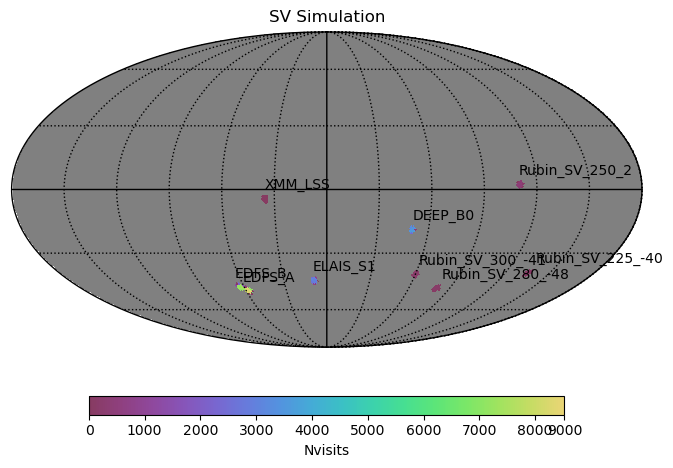

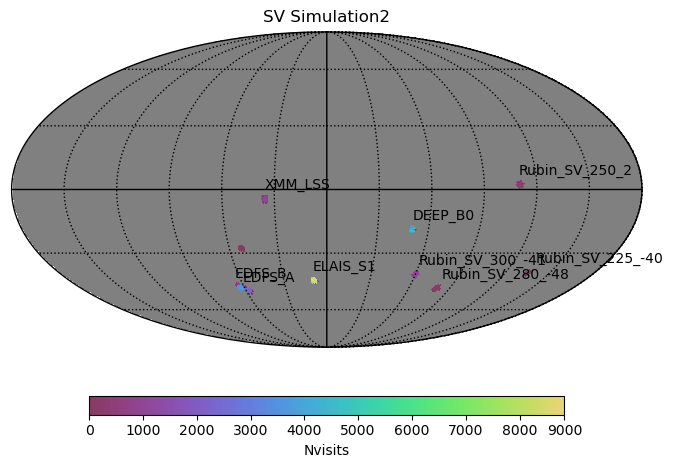

In [45]:
ph = maf.PlotHandler(out_dir=out_dir, thumbnail=False, fig_format='png')
ph.set_metric_bundles([bundle])
plot_dict = {'xlabel': 'Nvisits', 'title': "SV Simulation"}
fig = ph.plot(maf.HealpixSkyMap(), plot_dict)
field_dict = get_sv_fields()
for f in np.unique(visits_np['target']):
    hp.projtext(field_dict[f]['RA'], field_dict[f]['Dec']+5, f, lonlat=True)

ph = maf.PlotHandler(out_dir=out_dir, thumbnail=False, fig_format='png')
ph.set_metric_bundles([bundle2])
plot_dict = {'xlabel': 'Nvisits', 'title': "SV Simulation2"}
fig = ph.plot(maf.HealpixSkyMap(), plot_dict)
field_dict = get_sv_fields()
for f in np.unique(visits_np['target']):
    hp.projtext(field_dict[f]['RA'], field_dict[f]['Dec']+5, f, lonlat=True)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


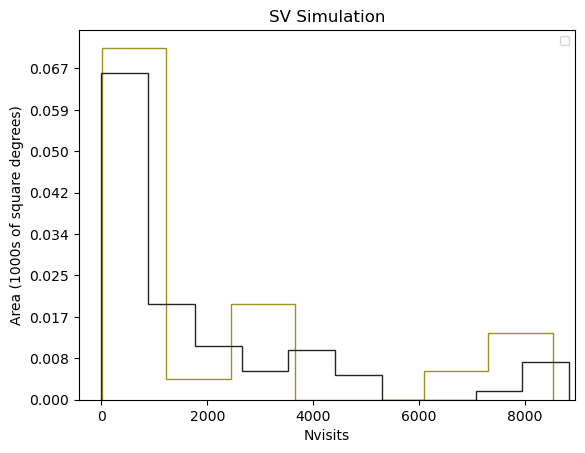

In [46]:
ph = maf.PlotHandler(out_dir=out_dir, thumbnail=False, fig_format='png')
ph.set_metric_bundles([bundle, bundle2])
plot_dict = {'xlabel': 'Nvisits', 'title': "SV Simulation"}
fig = ph.plot(maf.HealpixHistogram(), plot_dict)

In [48]:
visits.groupby('filter')['filter'].count(), visits2.groupby('filter')['filter'].count()

(filter
 g    4656
 i    5953
 r    6337
 u    2510
 y    2100
 z    3647
 Name: filter, dtype: int64,
 filter
 g    4316
 i    5665
 r    5895
 u    2352
 y    2042
 z    3647
 Name: filter, dtype: int64)

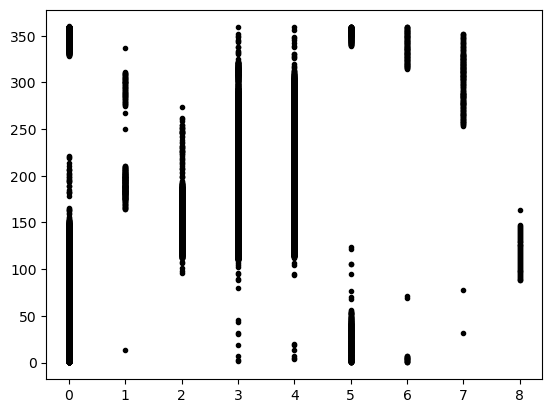

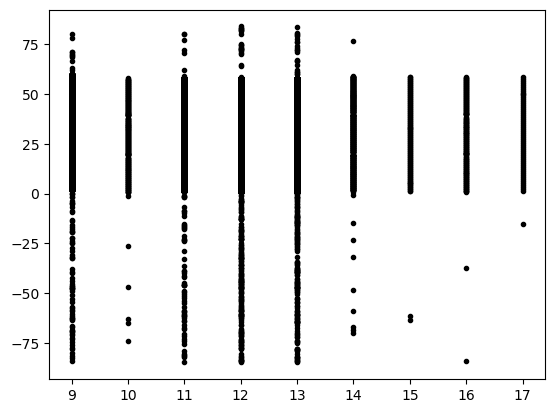

In [49]:
oi = 0
plt.figure()
for t in visits['target'].unique():
    tt = visits.query('target == @t')
    x = np.zeros(len(tt)) + oi
    oi += 1
    plt.plot(x, tt.rotSkyPos, 'k.')
plt.figure()
for t in visits['target'].unique():
    tt = visits.query('target == @t')
    x = np.zeros(len(tt)) + oi
    oi += 1
    plt.plot(x, tt.rotTelPos, 'k.')